## Setup

In [1]:
import os
import datetime
import sys

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from scipy.signal import savgol_filter
import random

# mapping '/' to __truediv__()
from __future__ import division 

from sklearn.metrics import mean_absolute_error
# possible alternative to above:
# tf.metrics.MeanAbsoluteError()

# helper code
from WindowGenerator import WindowGenerator
from Baseline import Baseline
from ModelGenerator import ModelGenerator

mpl.rcParams['figure.figsize'] = (12, 3)
mpl.rcParams['axes.grid'] = False

VERBOSE = True
MAX_EPOCHS = 30
INPUT_WIDTH = 3
SHIFT = 8
LABEL_WIDTH = 1
WINDOW_SIZE = INPUT_WIDTH + SHIFT

if VERBOSE:
    print('Setup Complete')

Setup Complete


## Import, Process, Graph

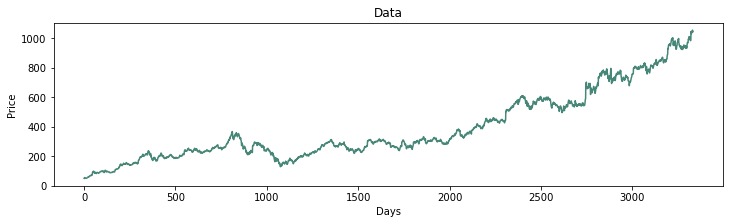

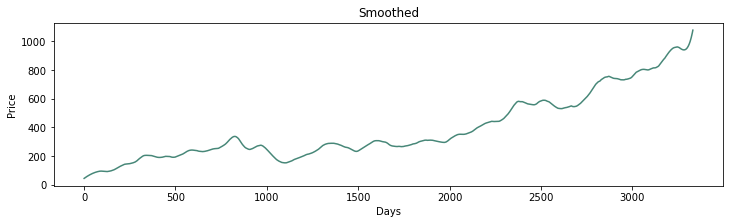

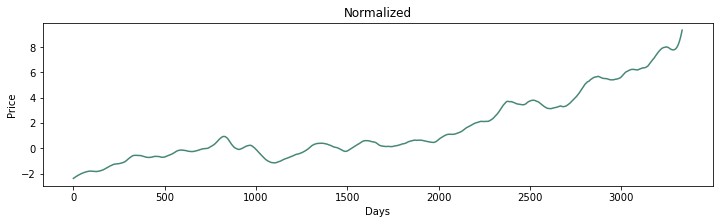

0      2004-08-19
1      2004-08-20
2      2004-08-23
3      2004-08-24
4      2004-08-25
          ...    
3328   2017-11-06
3329   2017-11-07
3330   2017-11-08
3331   2017-11-09
3332   2017-11-10
Name: ds, Length: 3333, dtype: datetime64[ns]
total samples = 3333
----------------------------------------
train_df samples = 2333
val_df samples = 666
test_df samples = 334
----------------------------------------
train + val + test = 3333


In [44]:
df = pd.read_csv('data/googl_edit.csv')
# print(df)

# throw out some data
start = 0 # 0
end = len(df['y']) # len(df['y'])
df_len = len(df['y'])
df = df.drop(index=range(0, start))
# print(df)
df = df.drop(index=range(end, df_len))
# print(df)
df = df.set_index(np.arange(0, len(df['y'])))
# print(df)

# seperate date_time
date_time = pd.to_datetime(df.pop('ds'), format='%Y-%m-%d %H:%M:%S')
# timestamp doesn't work if data is before 1970
if (date_time[0].year >= 1970):
    timestamp_s = date_time.map(datetime.datetime.timestamp)

plt.title('Data')
y = df['y']
x = np.arange( 0, len(y), 1 )
plt.ylabel('Price')
p1, = plt.plot( x, y, color='#478778' )
plt.xlabel('Days')
plt.show()

# smooth data
df['y'] = savgol_filter(df['y'], 155, 3) # window size, polynomial order

plt.title('Smoothed')
y = df['y']
x = np.arange( 0, len(y), 1 )
plt.ylabel('Price')
p1, = plt.plot( x, y, color='#478778' )
plt.xlabel('Days')
plt.show()

# split
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

# normalize
train_mean = train_df.mean()
train_std = train_df.std()
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

plt.title('Normalized')
df_std = (df - train_mean) / train_std
y = df_std['y']
x = np.arange( 0, len(y), 1 )
plt.ylabel('Price')
p1, = plt.plot( x, y, color='#478778' )
plt.xlabel('Days')
plt.show()

if VERBOSE:
    print( date_time )
    print( "total samples = {0:d}".format( n ) )
    print( "----------------------------------------" )
    print( "train_df samples = {0:d}".format( len( train_df ) ) )
    print( "val_df samples = {0:d}".format( len( val_df ) ) )
    print( "test_df samples = {0:d}".format( len( test_df ) ) )
    print( "----------------------------------------" )
    print( "train + val + test = {0:d}".format( len( train_df ) + len( val_df ) + len( test_df ) ) )

## Frequency

frequencies: 1667
years: 13.278884462151394


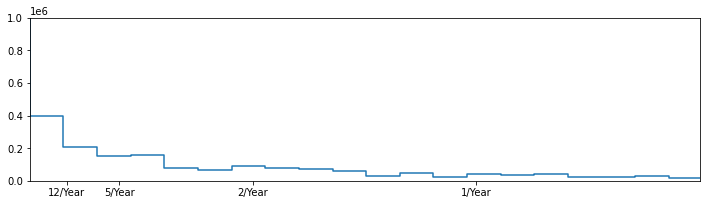

In [48]:
fft = tf.signal.rfft(df['y'])

# range for ibm: [10000:12000]

f_per_dataset = np.arange(0, len(fft))
n_samples_d = len(df['y'])
busi_days_per_year = 251 # less than business days but close to correct # of years
years_per_dataset = n_samples_d/(busi_days_per_year)
f_per_year = f_per_dataset/years_per_dataset

if VERBOSE:
    print(f'frequencies: {len(fft)}') # data_length / 2 + 1
    print(f'years: {years_per_dataset}')
    # print(f_per_year)

test = plt.step(f_per_year, np.abs(fft))
plt.ylim(0, 1000000)
plt.xlim([0.001, 1.5])
plt.xticks([0.083, 0.2, 0.5, 1], labels=['12/Year', '5/Year', '2/Year', '1/Year']) # f = 1/#years
plt.show()

## Make Model and Compile

In [49]:
model = ModelGenerator(train_df=train_df, val_df=val_df, test_df=test_df,
                            input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, 
                            shift=SHIFT, max_epochs=MAX_EPOCHS, label_columns=['y'])
if VERBOSE:
    print(model.conv_window)

Total window size: 11
Input indices: [0 1 2]
Label indices: [10]
Label column name(s): ['y']


mean absolute error (test): 0.136
adjusted mae (test): 34.466


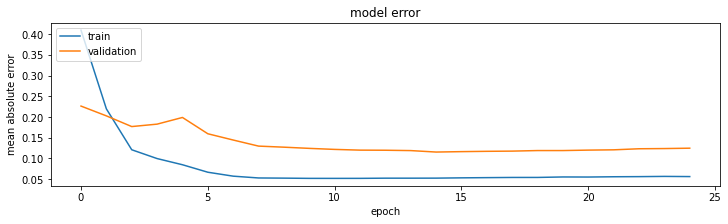

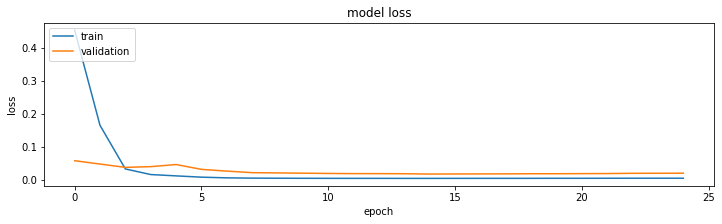

In [50]:
# train and eval model
history = model.compile_and_fit()
IPython.display.clear_output()

# use model on test
y, y_p, mae = model.test_model()
print( "mean absolute error (test): {0:0.3f}".format( mae ) )
print(f'adjusted mae (test): {round(float(mae*train_mean), 3)}')

plt.title('model error')
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.title('model loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Test Results

mean absolute error (test): 0.136
adjusted mae (test): 34.466


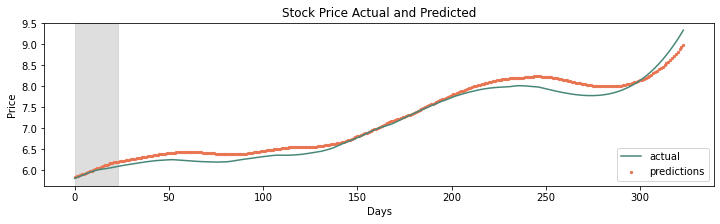

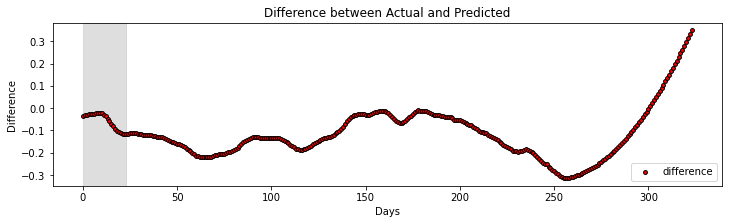

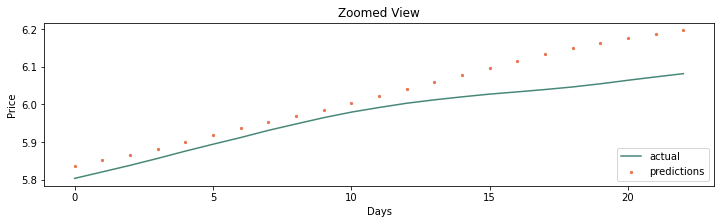

In [51]:
print( "mean absolute error (test): {0:0.3f}".format( mae ) )
print(f'adjusted mae (test): {round(float(mae*train_mean), 3)}')

x = np.arange( 0, len(y), 1 )
zoom_pwr = 14
zoom_idx = int(np.floor(len(y)/zoom_pwr))
x_zoom = np.arange(0, zoom_idx, 1)
y_zoom = y[: zoom_idx]
y_p_zoom = y_p[: zoom_idx]
shd_alpha = 0.6

plt.title('Stock Price Actual and Predicted')
plt.ylabel('Price')
plt.axvspan(0, zoom_idx, alpha=shd_alpha, color='#C9C9C9', zorder=0)
p1, = plt.plot( x, y, label='test', color='#478778' )
p2 = plt.scatter( x, y_p, edgecolors='#E97451', color='#E97451', s=5 )
plt.legend(handles=[p1, p2], labels=['actual', 'predictions'], loc='lower right')
plt.xlabel('Days')
plt.show()

plt.title('Difference between Actual and Predicted')
plt.ylabel('Difference')
p1 = plt.scatter( x, ( y-y_p ), edgecolors='black', color='red', s=15 )
plt.axvspan(0, zoom_idx, alpha=shd_alpha, color='#C9C9C9', zorder=0)
plt.legend(handles=[p1], labels=['difference'], loc='lower right')
plt.xlabel('Days')
plt.show()

plt.title('Zoomed View')
plt.ylabel('Price')
plt.plot( x_zoom, y_zoom, label='test', color='#478778' )
plt.scatter( x_zoom, y_p_zoom, edgecolors='#E97451', color='#E97451', s=5)
plt.legend(['actual', 'predictions'], loc='lower right')
plt.xlabel('Days')
plt.show()

## Real World Test
Make a single prediction based on the history of a different stock.

              ds        y
3340  1975-05-14  0.78885
3341  1975-05-15  0.78885
3342  1975-05-16  0.77710
3343  1975-05-19  0.76875
3344  1975-05-20  0.76875
3345  1975-05-21  0.74880
3346  1975-05-22  0.75280
3347  1975-05-23  0.76095
3348  1975-05-27  0.76095
3349  1975-05-28  0.75695
3350  1975-05-29  0.75280

Prediction:        0.7638


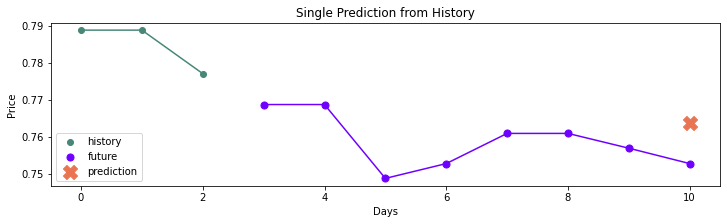

In [7]:
# specify pathname
pathname = 'data/ge_edit.csv'
df = pd.read_csv(pathname)
df_len = len(df['y'])

# adjust start_idx to pick a different range of values
start_idx = random.randint(0,len(df['y'])-WINDOW_SIZE)

start_idx = min(start_idx, len(df['y'])-WINDOW_SIZE)
start_idx = max(start_idx, 0)
# drop beginning
df = df.drop(index=range(0, start_idx))
# drop end
df = df.drop(index=range(start_idx+WINDOW_SIZE, df_len))

print(df)

# seperates date_time from df
date_time = pd.to_datetime(df.pop('ds'), format='%Y-%m-%d %H:%M:%S')
# timestamp_s = date_time.map(datetime.datetime.timestamp)

# divide dataframe
input_df = df[:INPUT_WIDTH]
future_df = df[INPUT_WIDTH:] # pretend we don't know these future values

# make prediction
y_p = model.single_window(df)

# history
y = input_df.to_numpy()
x = np.arange(0, len(y), 1)
# future
y_f = future_df.to_numpy()
x_f = np.arange(len(y), len(y) + len(y_f), 1)
# prediction
y_p = np.array( y_p )
x_p = WINDOW_SIZE-1

if VERBOSE:
    y_p_format = "{:.4f}".format(y_p[0])
    print(f"\nPrediction:        {y_p_format}")

# plot
plt.title('Single Prediction from History')
plt.ylabel('Price')
s1 = plt.scatter(x, y, edgecolors='#478778', color='#478778')
plt.plot(x, y, color='#478778')
s2 = plt.scatter(x_f, y_f, edgecolors='#6F00FF', color='#6F00FF', s=50)
plt.plot(x_f, y_f, color='#6F00FF')
s3 = plt.scatter(x_p, y_p, edgecolors='#E97451', color='#E97451', s=200, marker='X', zorder=10)
plt.legend(handles=[s1, s2, s3], labels=['history', 'future', 'prediction'], loc='lower left')
plt.xlabel('Days')
plt.show()

## Window Testing Loop
Test different window configs and record results.

In [ ]:
grid = []

for shift_idx in range(0,14+1):
    row = []
    for input_width_idx in range(1,14+1):
        model = ModelGenerator(train_df=train_df, val_df=val_df, test_df=test_df,
                            input_width=input_width_idx, label_width=LABEL_WIDTH, 
                            shift=shift_idx, max_epochs=MAX_EPOCHS, label_columns=['y'])
        history = model.compile_and_fit()
        IPython.display.clear_output()
        y, y_p, mae = model.test_model()
        mae = mae*train_mean
        row.append(mae)
    grid.append(row)
grid = np.array(grid)
np.save('data/perf_grid.npy', grid)
if VERBOSE:
    print('Done!')

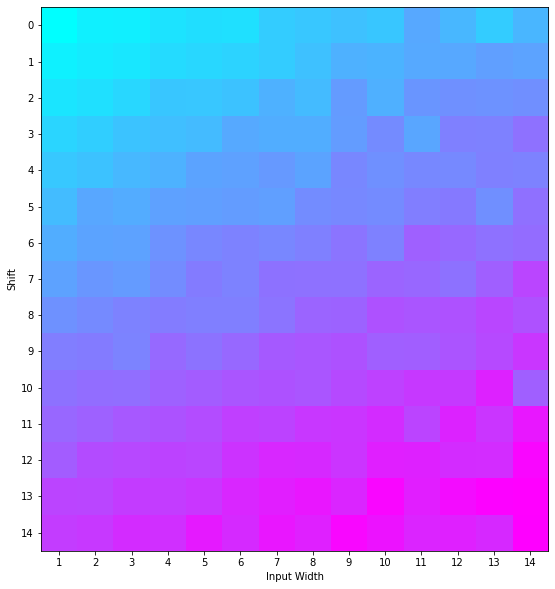

In [8]:
# load grid from drive
grid = np.load('data/perf_grid.npy')

plt.figure(figsize=(10,10))
plt.imshow(grid, cmap='cool', interpolation='nearest')
plt.yticks(range(0,14+1), range(0,14+1))
plt.xticks(range(0,13+1), range(1,14+1))
plt.xlabel('Input Width')
plt.ylabel('Shift')
plt.show()

## Chunks
Use data in chunks of 1k or 2k.

In [21]:
df = pd.read_csv('data/ibm_edit.csv')

# seperate date_time
date_time = pd.to_datetime(df.pop('ds'), format='%Y-%m-%d %H:%M:%S')
# timestamp doesn't work if data is before 1970
if (date_time[0].year >= 1970):
    timestamp_s = date_time.map(datetime.datetime.timestamp)

# smooth data
df['y'] = savgol_filter(df['y'], 155, 3) # window size, polynomial order

# make chunks
chunk_size = 2000
chunk_size = min(chunk_size, len(df['y']))
chunk_size = max(chunk_size, 1)
df_list = []
for i in range(0, len(df['y']), chunk_size):
    df_temp = df.drop(index=range(0, i))
    df_temp = df_temp.drop(index=range(i+chunk_size, len(df['y'])))
    df_temp = df_temp.set_index(np.arange(0, len(df_temp['y'])))
    df_list.append(df_temp)

# throw out small chunk
if (len(df_list[-1] < chunk_size)):
    df_list.pop(-1)

# ML with chunks
mae_list = []
for df in df_list:
    
    # split
    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[int(n*0.9):]
    
    # normalize
    train_mean = train_df.mean()
    train_std = train_df.std()
    train_df = (train_df - train_mean) / train_std
    val_df = (val_df - train_mean) / train_std
    test_df = (test_df - train_mean) / train_std
    
    # compile
    model = ModelGenerator(train_df=train_df, val_df=val_df, test_df=test_df,
                            input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, 
                            shift=SHIFT, max_epochs=MAX_EPOCHS, label_columns=['y'])
    history = model.compile_and_fit()
    IPython.display.clear_output()
    y, y_p, mae = model.test_model()
    mae = mae*train_mean
    mae_list.append(mae)

if VERBOSE:
    print("Done!")

Done!


In [22]:
i = 1
for num in mae_list:
    print(f"mae {i}: {round(num.at['y'], 4)}")
    i = i+1

mae 1: 1.7472
mae 2: 0.3343
mae 3: 2.5194
mae 4: 6.3045
mae 5: 3.5205
mae 6: 15.499
mae 7: 14.0145


## Optimal Window Analysis

In [40]:
grid = []
shift_vals = [1,2,3,7,14,21]

for shift_idx in shift_vals:
    row = []
    for input_width_idx in range(1,14+1):
        model = ModelGenerator(train_df=train_df, val_df=val_df, test_df=test_df,
                            input_width=input_width_idx, label_width=LABEL_WIDTH, 
                            shift=shift_idx, max_epochs=MAX_EPOCHS, label_columns=['y'])
        history = model.compile_and_fit()
        IPython.display.clear_output()
        y, y_p, mae = model.test_model()
        mae = mae*train_mean
        row.append(mae)
    grid.append(row)
grid = np.array(grid)
np.save('data/opt_perf_grid.npy', grid)
if VERBOSE:
    print('Done!')

Done!


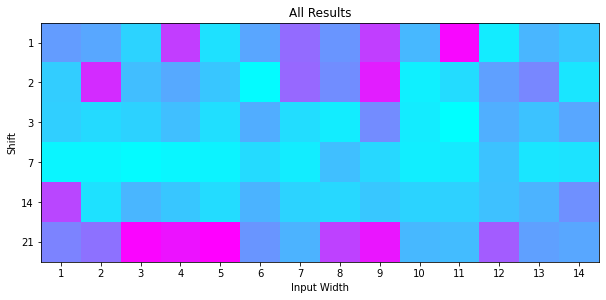

Best Widths:



,Width,MAE
1,12,2.089
2,6,1.503
3,11,1.303
7,3,1.486
14,2,2.534
21,11,4.049


In [43]:
# load grid from drive
grid = np.load('data/opt_perf_grid.npy')

plt.figure(figsize=(10,10))
plt.title('All Results')
plt.imshow(grid, cmap='cool', interpolation='nearest')
plt.yticks(range(0,5+1), shift_vals)
plt.xticks(range(0,13+1), range(1,14+1))
plt.xlabel('Input Width')
plt.ylabel('Shift')
plt.show()

best_widths = []
for sub_grid in grid:
    min_val = sys.maxsize
    count = 1
    for val_array in sub_grid:
        val = val_array[0]
        if val < min_val:
            best_width = count
            min_val = val
        count += 1
    best_widths.append([best_width, min_val])

temp = pd.DataFrame(best_widths)
temp.rename(columns={0:'Width',
                     1:'MAE'},
            index={0: 1,
                   1: 2,
                   2: 3,
                   3: 7,
                   4: 14,
                   5: 21
                  }, inplace=True)
temp['MAE'] = temp['MAE'].astype(float).round(3)

print('Best Widths:\n')
display(temp)

## Multiple Stock Spreadsheet

In [12]:
stock_list = [
    "adbe",
    "all",
    "amd",
    "amzn",
    "csco",
    "ebay",
    "ge",
    "googl",
    "grmn",
    "ibm",
    "msft",
    "nke",
    "nvda",
    "orcl",
    "siri",
    "xlnx"
]

In [13]:
stock_info = []
for stock_name in stock_list:
    
    ###
    ### total stats
    ###
    
    # load file
    df = pd.read_csv(f'data/{stock_name}_edit.csv')
    
    # stock data
    stock_row = [stock_name]

    # seperate date_time
    date_time = pd.to_datetime(df.pop('ds'), format='%Y-%m-%d %H:%M:%S')
    # timestamp doesn't work if data is before 1970
    if (date_time[0].year >= 1970):
        timestamp_s = date_time.map(datetime.datetime.timestamp)

    # smooth data
    df['y'] = savgol_filter(df['y'], 155, 3) # window size, polynomial order
    
    # split
    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[int(n*0.9):]

    # normalize
    train_mean = train_df.mean()
    train_std = train_df.std()
    train_df = (train_df - train_mean) / train_std
    val_df = (val_df - train_mean) / train_std
    test_df = (test_df - train_mean) / train_std
    
    # frequencies
    fft = tf.signal.rfft(df['y'])
    
    f_per_dataset = np.arange(0, len(fft))
    n_samples_d = len(df['y'])
    busi_days_per_year = 251 # less than business days but close to correct # of years
    years_per_dataset = n_samples_d/(busi_days_per_year)
    f_per_year = f_per_dataset/years_per_dataset

    test = plt.step(f_per_year, np.abs(fft))
    plt.close() # turn off display for frequency plots
    x,y = test[0].get_data()
    # x is list of f = 1/#years, y is list of # of frequencies
    
    # find top 3 frequencies
    temp_freqs = sorted(zip(y, x), reverse=True)[:3]
    total_freqs = []
    for pair in temp_freqs:
        _,temp = pair
        temp = 1/temp # convert to #years
        total_freqs.append(temp)
    
    # find best width for shift=21 and mae for total
    mae_list = []
    for input_width_idx in range(1,14+1):
        model = ModelGenerator(train_df=train_df, val_df=val_df, test_df=test_df,
                            input_width=input_width_idx, label_width=LABEL_WIDTH, 
                            shift=21, max_epochs=MAX_EPOCHS, label_columns=['y'])
        history = model.compile_and_fit()
        IPython.display.clear_output()
        y, y_p, mae = model.test_model()
        mae = mae*train_mean
        mae_list.append(mae)
    
#     print(mae_list)
    
    # add best mae and width to row
    min_mae = sys.maxsize
    count = 1
    for val_array in mae_list:
        val = val_array[0]
        if val < min_mae:
            best_width = count
            min_mae = val
        count += 1
    
#     print(min_mae)
#     print(best_width)
#     name
    
    # average price
    avg_price = np.average(df['y'])
    
    # add stats
    stock_row.append(min_mae)
    stock_row.append(avg_price)
    stock_row.append(21)
    stock_row.append(best_width)
    
    ###
    ### chunk stats
    ###
    
    # load fresh file
    df = pd.read_csv(f'data/{stock_name}_edit.csv')

    # seperate date_time
    date_time = pd.to_datetime(df.pop('ds'), format='%Y-%m-%d %H:%M:%S')
    # timestamp doesn't work if data is before 1970
    if (date_time[0].year >= 1970):
        timestamp_s = date_time.map(datetime.datetime.timestamp)

    # smooth data
    df['y'] = savgol_filter(df['y'], 155, 3) # window size, polynomial order

    # make chunks
    chunk_size = 2000
    chunk_size = min(chunk_size, len(df['y']))
    chunk_size = max(chunk_size, 1)
    df_list = []
    for i in range(0, len(df['y']), chunk_size):
        df_temp = df.drop(index=range(0, i))
        df_temp = df_temp.drop(index=range(i+chunk_size, len(df['y'])))
        df_temp = df_temp.set_index(np.arange(0, len(df_temp['y'])))
        df_list.append(df_temp)

    # throw out small chunk
    if (len(df_list[-1] < chunk_size)):
        df_list.pop(-1)

    # ML with chunks
    mae_grid = []
    chunk_freqs_list = []
    for df in df_list:

        # split
        n = len(df)
        train_df = df[0:int(n*0.7)]
        val_df = df[int(n*0.7):int(n*0.9)]
        test_df = df[int(n*0.9):]

        # normalize
        train_mean = train_df.mean()
        train_std = train_df.std()
        train_df = (train_df - train_mean) / train_std
        val_df = (val_df - train_mean) / train_std
        test_df = (test_df - train_mean) / train_std
        
        # frequencies
        fft = tf.signal.rfft(df['y'])

        f_per_dataset = np.arange(0, len(fft))
        n_samples_d = len(df['y'])
        busi_days_per_year = 251 # less than business days but close to correct # of years
        years_per_dataset = n_samples_d/(busi_days_per_year)
        f_per_year = f_per_dataset/years_per_dataset

        test = plt.step(f_per_year, np.abs(fft))
        plt.close() # turn off display for frequency plots
        x,y = test[0].get_data()
        # x is list of f = 1/#years, y is list of # of frequencies

        # find top 3 frequencies
        temp_freqs = sorted(zip(y, x), reverse=True)[:3]
        chunk_freqs = []
        for pair in temp_freqs:
            _,temp = pair
            temp = 1/temp # convert to #years
            chunk_freqs.append(temp)
        chunk_freqs_list.append(chunk_freqs)
        
        # test all widths for shift=21
        mae_list = []
        for input_width_idx in range(1,14+1):
            model = ModelGenerator(train_df=train_df, val_df=val_df, test_df=test_df,
                                input_width=input_width_idx, label_width=LABEL_WIDTH, 
                                shift=21, max_epochs=MAX_EPOCHS, label_columns=['y'])
            history = model.compile_and_fit()
            IPython.display.clear_output()
            y, y_p, mae = model.test_model()
            mae = mae*train_mean
            mae_list.append(mae)
        mae_grid.append(mae_list)
        
    #########################################
    ## Check mae grid #######################
    #########################################
    
#     plt.figure(figsize=(10,10))
#     plt.title('All Results')
#     plt.imshow(mae_grid, cmap='cool', interpolation='nearest')
#     plt.yticks([0], [21])
#     plt.xticks(range(0,13+1), range(1,14+1))
#     plt.xlabel('Input Width')
#     plt.ylabel('Shift')
#     plt.show()
    
#     print(mae_grid)
    
    #########################################
    
    # find best mae (and width) for each chunk
    min_mae_list = []
    best_width_list = []
    for mae_list in mae_grid:
        min_mae = sys.maxsize
        count = 1
        for val_array in mae_list:
            val = val_array[0]
            if val < min_mae:
                best_width = count
                min_mae = val
            count += 1
        min_mae_list.append(min_mae)
        best_width_list.append(best_width)
    
#     print(min_mae_list)
#     print(best_width_list)
    
    # find mean and stdev of best mae values
    mean_mae = np.average(min_mae_list)
    mean_width = int(round(np.average(best_width_list), 0))
    std_mae = np.std(min_mae_list)
    
    # add stats
    stock_row.append(mean_mae)
    stock_row.append(std_mae)
    stock_row.append(21)
    stock_row.append(mean_width)
    
    
    # average chunk freqs
    firsts = []
    seconds = []
    thirds = []
    for sub_list in chunk_freqs_list:
        firsts.append(sub_list[0])
        seconds.append(sub_list[1])
        thirds.append(sub_list[2])
    avg_chunk_first = np.average(firsts)
    avg_chunk_second = np.average(seconds)
    avg_chunk_third = np.average(thirds)
    avg_chunk_freqs = [avg_chunk_first, avg_chunk_second, avg_chunk_third]
    
    # add stats
    for val in total_freqs:
        stock_row.append(val)
    for val in avg_chunk_freqs:
        stock_row.append(val)
    
    # add row to table
    stock_info.append(stock_row)

np.save('data/stock_info3.npy', stock_info)
print("Done!")

Done!


In [14]:
stock_info = np.load('data/stock_info3.npy')
stock_info = pd.DataFrame(stock_info)
stock_info.rename(columns={0:'Name',
                           1:'AVG price ($)',
                           2:'MAE (~$)',
                           3:'Shift (Days)',
                           4:'Width (Days)',
                           5:'Mean MAE (~$)',
                           6:'STD MAE (~$)',
                           7:'Shift (Days)',
                           8:'Width (Days)',
                           9:'1st Freq (Years)',
                           10:'2nd Freq (Years)',
                           11:'3rd Freq (Years)',
                           12:'Avg 1st Freq (Years)',
                           13:'Avg 2nd Freq (Years)',
                           14:'Avg 3rd Freq (Years)'
                          }, inplace=True)
stock_info['AVG price ($)'] = stock_info['AVG price ($)'].astype(float).round(3)
stock_info['MAE (~$)'] = stock_info['MAE (~$)'].astype(float).round(3)
stock_info['Mean MAE (~$)'] = stock_info['Mean MAE (~$)'].astype(float).round(3)
stock_info['STD MAE (~$)'] = stock_info['STD MAE (~$)'].astype(float).round(3)
stock_info['1st Freq (Years)'] = stock_info['1st Freq (Years)'].astype(float).round(1)
stock_info['2nd Freq (Years)'] = stock_info['2nd Freq (Years)'].astype(float).round(1)
stock_info['3rd Freq (Years)'] = stock_info['3rd Freq (Years)'].astype(float).round(1)
stock_info['Avg 1st Freq (Years)'] = stock_info['Avg 1st Freq (Years)'].astype(float).round(1)
stock_info['Avg 2nd Freq (Years)'] = stock_info['Avg 2nd Freq (Years)'].astype(float).round(1)
stock_info['Avg 3rd Freq (Years)'] = stock_info['Avg 3rd Freq (Years)'].astype(float).round(1)
display(stock_info)

,Name,AVG price ($),MAE (~$),Shift (Days),Width (Days),Mean MAE (~$),STD MAE (~$),Shift (Days),Width (Days),1st Freq (Years),2nd Freq (Years),3rd Freq (Years),Avg 1st Freq (Years),Avg 2nd Freq (Years),Avg 3rd Freq (Years)
0,adbe,11.266,26.556,21,2,1.579,0.984,21,9,inf,31.4,15.7,inf,8.0,3.1
1,all,26.860,36.432,21,3,8.321,8.220,21,2,inf,12.3,8.2,inf,8.0,2.4
2,amd,0.990,10.830,21,6,1.395,0.482,21,10,inf,34.8,17.4,inf,7.0,3.2
3,amzn,21.003,181.611,21,12,3.488,1.185,21,2,inf,20.5,10.3,inf,6.0,3.3
4,csco,0.749,15.559,21,1,0.967,0.453,21,5,inf,13.9,27.7,inf,4.9,6.6
5,ebay,8.106,15.004,21,2,2.980,0.537,21,6,inf,9.6,19.2,inf,8.0,3.3
6,ge,1.536,10.532,21,9,2.027,2.584,21,4,inf,56.0,14.0,inf,7.4,3.9
7,googl,53.575,389.692,21,1,29.474,0.000,21,1,inf,13.3,6.6,inf,4.0,2.0
8,grmn,1.807,29.820,21,10,6.436,3.257,21,1,inf,8.5,3.4,inf,8.0,3.0
9,ibm,4.091,48.550,21,7,9.854,12.032,21,7,inf,56.0,28.0,inf,7.4,4.6
